In [1]:
# !pip install opencv-python scikit-learn pandas numpy matplotlib tensorflow-addons
# !pip install tensorflow==2.12 keras==2.12
# !pip install transformers datasets torchvision

In [1]:
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, Multiply, GlobalAveragePooling2D, Dense, Input, Softmax, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import kagglehub
from transformers import ViTImageProcessor, ViTForImageClassification
import torch
from datasets import load_dataset
from PIL import Image
import requests
from sklearn.metrics import classification_report
import torch
from torch.optim import AdamW 
from transformers import ViTFeatureExtractor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

2025-08-07 13:15:02.505522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754572502.666333      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754572502.712503      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")
print("Path to dataset files:", path)
path = kagglehub.dataset_download("justinkirby/the-cancer-imaging-archive-lidcidri")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/iqothnccd-lung-cancer-dataset
Path to dataset files: /kaggle/input/the-cancer-imaging-archive-lidcidri


In [3]:
data_dir = '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
test_dir = '/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases'

In [4]:
img_size = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 878 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


In [5]:
print(train_generator.class_indices)

{'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}


In [6]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# y_train = train_generator.classes  

# #Compute class weightss
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )

# # Convert to dict for Keras
# class_weights_dict = dict(enumerate(class_weights))

# print("Class Weights:", class_weights_dict)

In [7]:
import torch
import numpy as np
import cv2
import os
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import DeiTForImageClassification, AutoImageProcessor

# Load DeiT processor and model
processor = AutoImageProcessor.from_pretrained('facebook/deit-base-distilled-patch16-224')

# Custom preprocessing function
def custom_preprocess(img):
    img_np = np.array(img)
    if img_np.ndim == 3 and img_np.shape[2] == 3:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_np = clahe.apply(img_np)
    img_np = cv2.resize(img_np, (224, 224), interpolation=cv2.INTER_CUBIC)
    img_np = cv2.GaussianBlur(img_np, (5,5), 0)
    _, img_np = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    img_np = cv2.erode(img_np, kernel, iterations=1)
    img_np = cv2.dilate(img_np, kernel, iterations=1)
    return Image.fromarray(img_np)

# Transforms
train_transform = transforms.Compose([
    transforms.Lambda(custom_preprocess),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

val_transform = transforms.Compose([
    transforms.Lambda(custom_preprocess),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])


data_dir = '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
test_dir = '/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases'


full_dataset = datasets.ImageFolder(root=data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


num_classes = len(full_dataset.classes)
model = DeiTForImageClassification.from_pretrained(
    'facebook/deit-base-distilled-patch16-224',
    num_labels=num_classes
)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Dataset loaded: {len(full_dataset)} samples")
print(f"Classes: {full_dataset.classes}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")
print(f"Device: {device}")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

Dataset loaded: 1097 samples
Classes: ['Bengin cases', 'Malignant cases', 'Normal cases']
Train: 877, Val: 220
Device: cuda


In [8]:
model = DeiTForImageClassification.from_pretrained(
    'facebook/deit-base-distilled-patch16-224',
    num_labels=3
)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import copy

best_val_loss = float('inf')
best_model_state = None

In [10]:
from torch.utils.data import random_split

full_dataset = datasets.ImageFolder(root=data_dir)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [11]:
import torch
import copy
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


train_labels = [full_dataset.samples[i][1] for i in train_dataset.indices]


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=5e-5)

best_val_loss = float('inf')
best_model_state = None

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import torch
from torch.utils.data import Subset
import copy
from tqdm import tqdm

# Training configuration
CONFIG = {
    'n_splits': 5,
    'epochs': 15,
    'batch_size': 32,
    'lr': 2e-5,
    'weight_decay': 0.01,
    'patience': 3,
    'min_delta': 1e-4
}

def train_epoch(model, loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(loader), correct / total

def validate(model, loader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            outputs = model(inputs).logits
            loss = loss_fn(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(loader), correct / total

# Prepare stratified splits
all_labels = [sample[1] for sample in full_dataset.samples]
skf = StratifiedKFold(n_splits=CONFIG['n_splits'], shuffle=True, random_state=42)
fold_results = []

print(f"Starting {CONFIG['n_splits']}-fold cross-validation")
print(f"Total samples: {len(full_dataset)}")

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels), 1):
    print(f"\n{'='*50}")
    print(f"FOLD {fold}/{CONFIG['n_splits']}")
    print(f"{'='*50}")
    
    # Create subsets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    # Apply transforms
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_transform
    
    # Data loaders with optimizations
    train_loader = DataLoader(
        train_subset, 
        batch_size=CONFIG['batch_size'], 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_subset, 
        batch_size=CONFIG['batch_size'], 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Initialize model
    model = DeiTForImageClassification.from_pretrained(
        'facebook/deit-base-distilled-patch16-224',
        num_labels=num_classes
    ).to(device)
    
    # Optimizer and scheduler
    optimizer = AdamW(
        model.parameters(), 
        lr=CONFIG['lr'], 
        weight_decay=CONFIG['weight_decay']
    )
    total_steps = len(train_loader) * CONFIG['epochs']
    scheduler = CosineAnnealingLR(optimizer, T_max=total_steps)
    
    # Training loop with early stopping
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    print(f"Train samples: {len(train_subset)}, Val samples: {len(val_subset)}")
    
    fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(CONFIG['epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
                
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, loss_fn, device)
        
        # Store history
        fold_history['train_loss'].append(train_loss)
        fold_history['train_acc'].append(train_acc)
        fold_history['val_loss'].append(val_loss)
        fold_history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Early stopping check
        if val_acc > best_val_acc + CONFIG['min_delta']:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print("✅ New best model!")
        else:
            patience_counter += 1
            if patience_counter >= CONFIG['patience']:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Save best model for this fold
    torch.save(best_model_state, f"best_model_fold{fold}.pth")
    print(f"Best accuracy for fold {fold}: {best_val_acc:.4f}")
    
    fold_results.append({
        'fold': fold,
        'best_accuracy': best_val_acc,
        'history': fold_history
    })

# Final results
accuracies = [result['best_accuracy'] for result in fold_results]
print(f"\n{'='*60}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*60}")
for i, acc in enumerate(accuracies, 1):
    print(f"Fold {i}: {acc:.4f}")
print(f"{'='*60}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Best Fold: {np.argmax(accuracies) + 1} ({np.max(accuracies):.4f})")
print(f"{'='*60}")

# Clean up GPU memory
torch.cuda.empty_cache()

Starting 5-fold cross-validation
Total samples: 1097

FOLD 1/5


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train samples: 877, Val samples: 220

Epoch 1/15


Train Loss: 0.7409, Train Acc: 0.7389
Val Loss: 0.5268, Val Acc: 0.8500
✅ New best model!

Epoch 2/15


Train Loss: 0.4060, Train Acc: 0.9612
Val Loss: 0.4142, Val Acc: 0.9409
✅ New best model!

Epoch 3/15


Train Loss: 0.3210, Train Acc: 0.9966
Val Loss: 0.3654, Val Acc: 0.9773
✅ New best model!

Epoch 4/15


Train Loss: 0.3036, Train Acc: 0.9989
Val Loss: 0.3413, Val Acc: 0.9818
✅ New best model!

Epoch 5/15


Train Loss: 0.2964, Train Acc: 1.0000
Val Loss: 0.3397, Val Acc: 0.9818

Epoch 6/15


Train Loss: 0.2933, Train Acc: 1.0000
Val Loss: 0.3381, Val Acc: 0.9864
✅ New best model!

Epoch 7/15


Train Loss: 0.2923, Train Acc: 1.0000
Val Loss: 0.3393, Val Acc: 0.9818

Epoch 8/15


Train Loss: 0.2918, Train Acc: 1.0000
Val Loss: 0.3383, Val Acc: 0.9818

Epoch 9/15


Train Loss: 0.2916, Train Acc: 1.0000
Val Loss: 0.3385, Val Acc: 0.9818
Early stopping triggered after 9 epochs
Best accuracy for fold 1: 0.9864

FOLD 2/5


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train samples: 877, Val samples: 220

Epoch 1/15


Train Loss: 0.7264, Train Acc: 0.7640
Val Loss: 0.4875, Val Acc: 0.8909
✅ New best model!

Epoch 2/15


Train Loss: 0.3959, Train Acc: 0.9578
Val Loss: 0.3882, Val Acc: 0.9682
✅ New best model!

Epoch 3/15


Train Loss: 0.3170, Train Acc: 0.9966
Val Loss: 0.3527, Val Acc: 0.9818
✅ New best model!

Epoch 4/15


Train Loss: 0.3016, Train Acc: 0.9989
Val Loss: 0.3426, Val Acc: 0.9818

Epoch 5/15


Train Loss: 0.2952, Train Acc: 1.0000
Val Loss: 0.3425, Val Acc: 0.9773

Epoch 6/15


Train Loss: 0.2933, Train Acc: 1.0000
Val Loss: 0.3404, Val Acc: 0.9773
Early stopping triggered after 6 epochs
Best accuracy for fold 2: 0.9818

FOLD 3/5


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train samples: 878, Val samples: 219

Epoch 1/15


Train Loss: 0.7139, Train Acc: 0.7472
Val Loss: 0.5234, Val Acc: 0.8630
✅ New best model!

Epoch 2/15


Train Loss: 0.4064, Train Acc: 0.9396
Val Loss: 0.4716, Val Acc: 0.9087
✅ New best model!

Epoch 3/15


Train Loss: 0.3272, Train Acc: 0.9943
Val Loss: 0.3627, Val Acc: 0.9726
✅ New best model!

Epoch 4/15


Train Loss: 0.3029, Train Acc: 0.9989
Val Loss: 0.3518, Val Acc: 0.9726

Epoch 5/15


Train Loss: 0.2973, Train Acc: 1.0000
Val Loss: 0.3589, Val Acc: 0.9772
✅ New best model!

Epoch 6/15


Train Loss: 0.2951, Train Acc: 1.0000
Val Loss: 0.3510, Val Acc: 0.9817
✅ New best model!

Epoch 7/15


Train Loss: 0.2926, Train Acc: 1.0000
Val Loss: 0.3508, Val Acc: 0.9863
✅ New best model!

Epoch 8/15


Train Loss: 0.2918, Train Acc: 1.0000
Val Loss: 0.3485, Val Acc: 0.9863

Epoch 9/15


Train Loss: 0.2916, Train Acc: 1.0000
Val Loss: 0.3481, Val Acc: 0.9909
✅ New best model!

Epoch 10/15


Train Loss: 0.2915, Train Acc: 1.0000
Val Loss: 0.3483, Val Acc: 0.9909

Epoch 11/15


Train Loss: 0.2914, Train Acc: 1.0000
Val Loss: 0.3483, Val Acc: 0.9909

Epoch 12/15


Train Loss: 0.2914, Train Acc: 1.0000
Val Loss: 0.3481, Val Acc: 0.9909
Early stopping triggered after 12 epochs
Best accuracy for fold 3: 0.9909

FOLD 4/5


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train samples: 878, Val samples: 219

Epoch 1/15


Train Loss: 0.7267, Train Acc: 0.7449
Val Loss: 0.4941, Val Acc: 0.8721
✅ New best model!

Epoch 2/15


Train Loss: 0.4048, Train Acc: 0.9510
Val Loss: 0.3980, Val Acc: 0.9406
✅ New best model!

Epoch 3/15


Train Loss: 0.3140, Train Acc: 0.9989
Val Loss: 0.3652, Val Acc: 0.9726
✅ New best model!

Epoch 4/15


Train Loss: 0.2998, Train Acc: 1.0000
Val Loss: 0.3470, Val Acc: 0.9726

Epoch 5/15


Train Loss: 0.2951, Train Acc: 1.0000
Val Loss: 0.3513, Val Acc: 0.9680

Epoch 6/15


Train Loss: 0.2930, Train Acc: 1.0000
Val Loss: 0.3443, Val Acc: 0.9726
Early stopping triggered after 6 epochs
Best accuracy for fold 4: 0.9726

FOLD 5/5


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train samples: 878, Val samples: 219

Epoch 1/15


Train Loss: 0.7641, Train Acc: 0.6982
Val Loss: 0.4980, Val Acc: 0.8767
✅ New best model!

Epoch 2/15


Train Loss: 0.4198, Train Acc: 0.9339
Val Loss: 0.3746, Val Acc: 0.9726
✅ New best model!

Epoch 3/15


Train Loss: 0.3231, Train Acc: 0.9954
Val Loss: 0.3368, Val Acc: 0.9909
✅ New best model!

Epoch 4/15


Train Loss: 0.3048, Train Acc: 0.9966
Val Loss: 0.3205, Val Acc: 0.9954
✅ New best model!

Epoch 5/15


Train Loss: 0.2970, Train Acc: 1.0000
Val Loss: 0.3218, Val Acc: 0.9954

Epoch 6/15


Train Loss: 0.2944, Train Acc: 1.0000
Val Loss: 0.3162, Val Acc: 0.9954

Epoch 7/15


Train Loss: 0.2926, Train Acc: 1.0000
Val Loss: 0.3156, Val Acc: 0.9954
Early stopping triggered after 7 epochs
Best accuracy for fold 5: 0.9954

CROSS-VALIDATION RESULTS
Fold 1: 0.9864
Fold 2: 0.9818
Fold 3: 0.9909
Fold 4: 0.9726
Fold 5: 0.9954
Mean Accuracy: 0.9854 ± 0.0078
Best Fold: 5 (0.9954)


EVALUATION RESULTS
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.96      0.98        24
Malignant cases       1.00      1.00      1.00       112
   Normal cases       0.99      1.00      0.99        83

       accuracy                           1.00       219
      macro avg       1.00      0.99      0.99       219
   weighted avg       1.00      1.00      1.00       219

Overall Accuracy: 0.9954


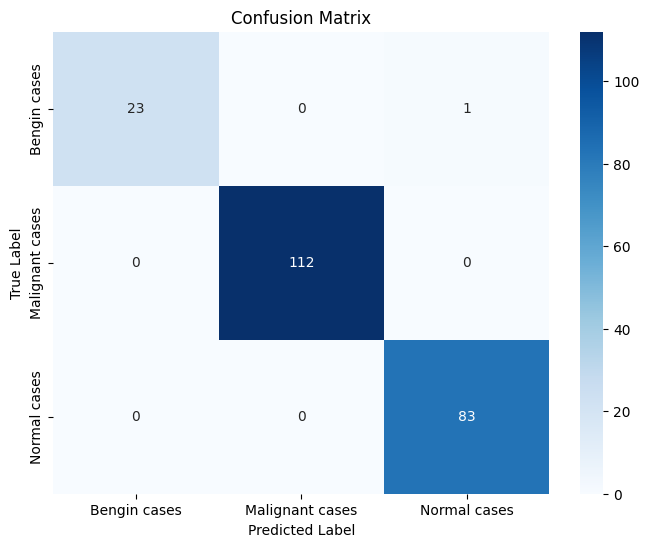

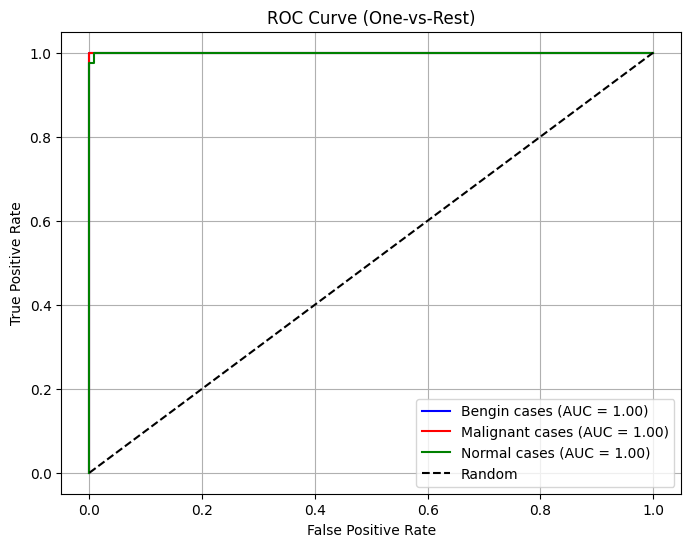

Bengin cases Accuracy: 0.9583
Malignant cases Accuracy: 1.0000
Normal cases Accuracy: 1.0000


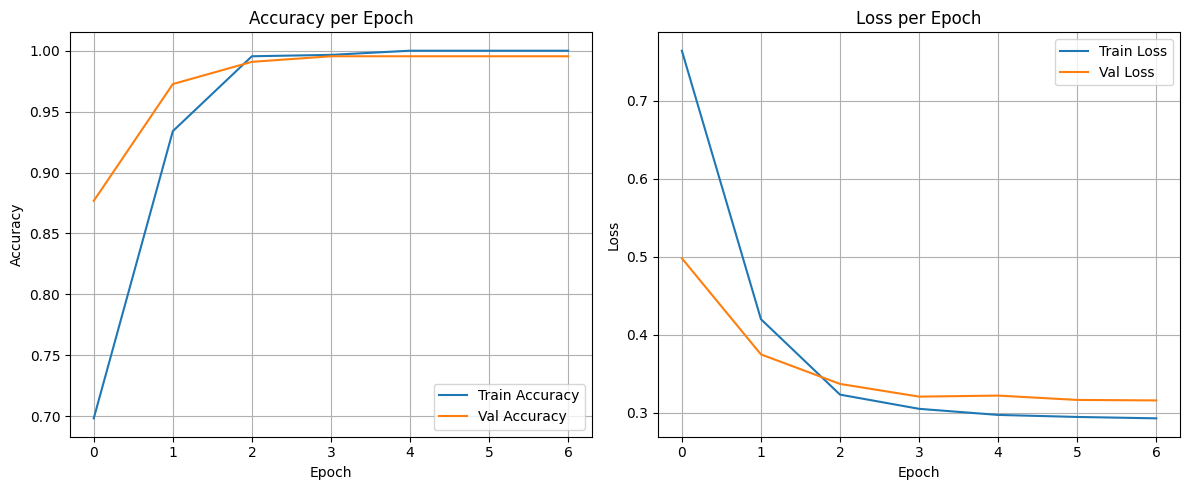

In [44]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        logits = model(inputs).logits
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print detailed metrics
print("="*60)
print("EVALUATION RESULTS")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.classes, 
            yticklabels=full_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Per-class accuracy
for i, class_name in enumerate(full_dataset.classes):
    class_mask = np.array(all_labels) == i
    if class_mask.sum() > 0:
        class_acc = (np.array(all_preds)[class_mask] == i).mean()
        print(f"{class_name} Accuracy: {class_acc:.4f}")

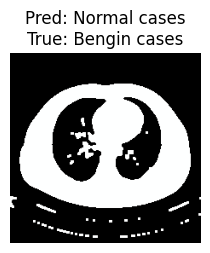

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Misclassified image collection
misclassified = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs).logits
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        
        for i in range(inputs.size(0)):
            if preds[i] != labels[i]:
                misclassified.append((
                    inputs[i].cpu(),
                    preds[i].item(),
                    labels[i].item()
                ))


classes = full_dataset.classes
num_images = min(24, len(misclassified)) 
cols = 6
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(15, rows * 2.5))
for i in range(num_images):
    img_tensor, pred, true = misclassified[i]
    img_np = img_tensor.permute(1, 2, 0).numpy()
    
    # Unnormalize (if needed)
    mean = np.array(processor.image_mean)
    std = np.array(processor.image_std)
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    plt.subplot(rows, cols, i+1)
    plt.imshow(img_np)
    plt.title(f"Pred: {classes[pred]}\nTrue: {classes[true]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


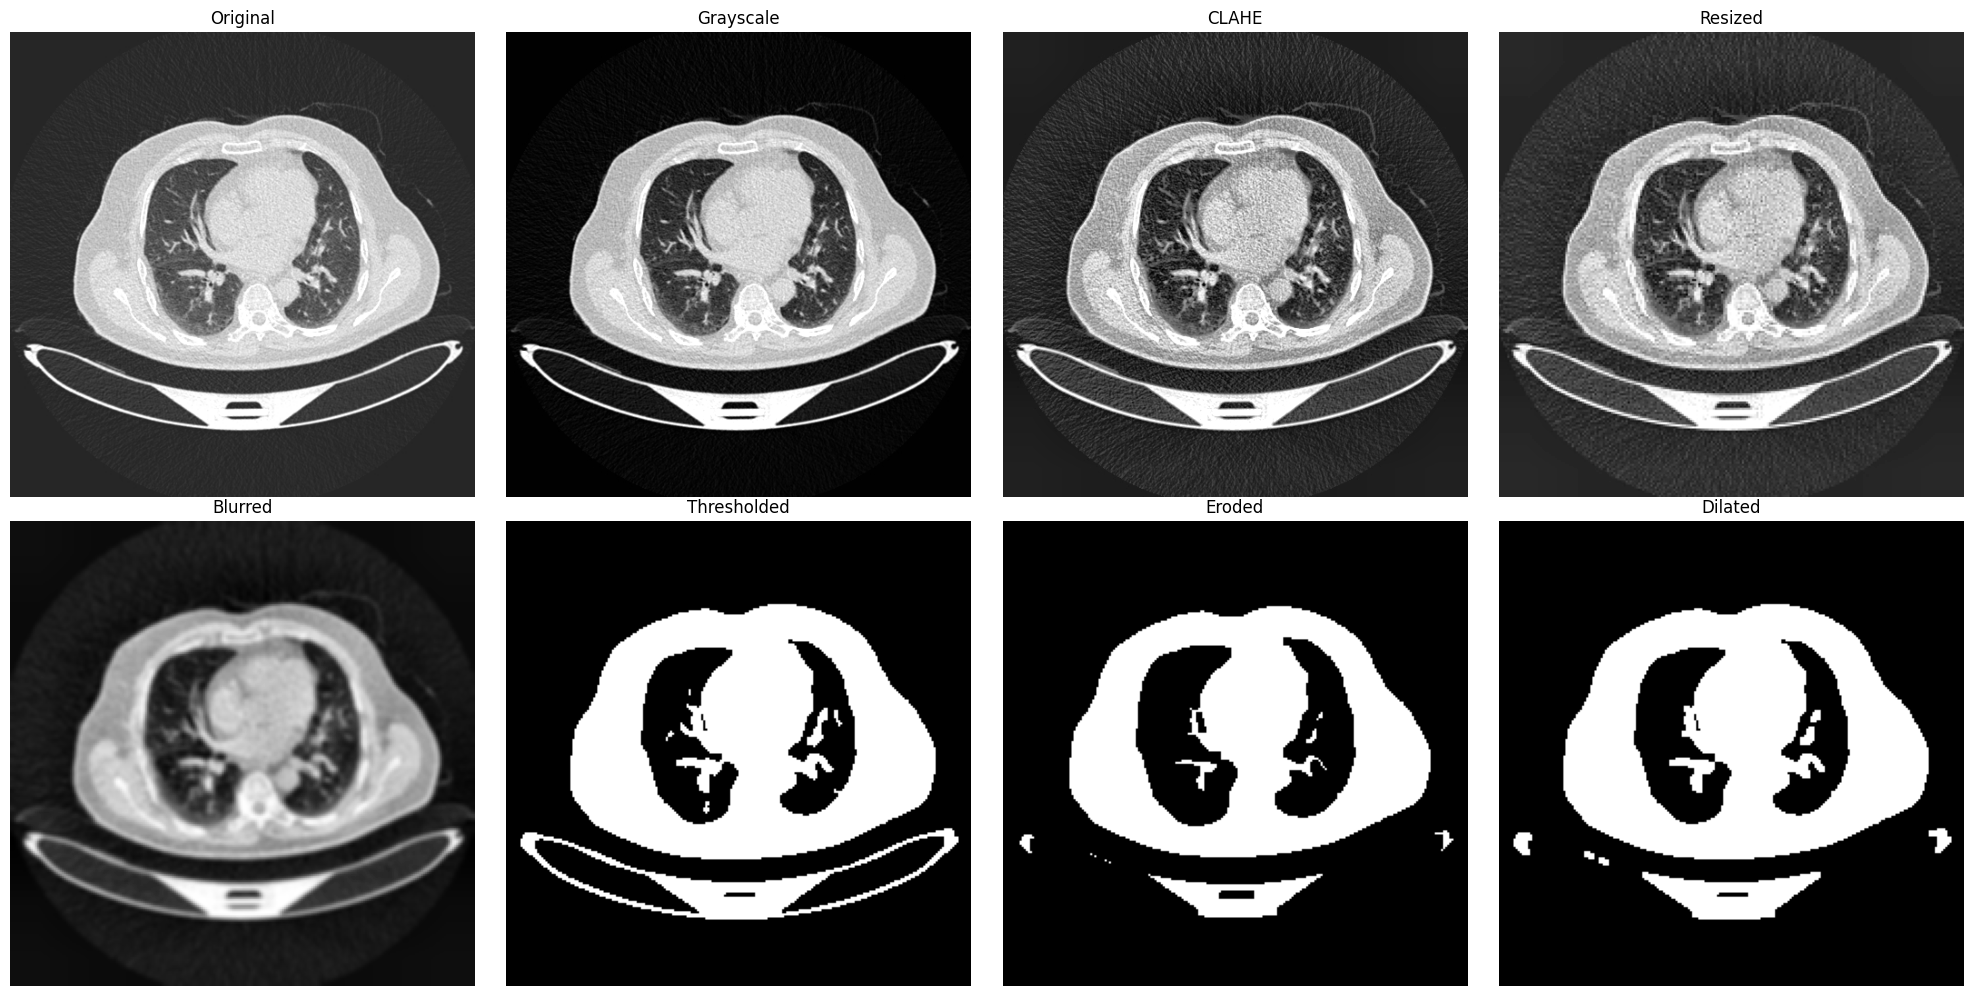

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_custom_preprocess(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)

    steps = {}
    steps['Original'] = img_np.copy()

    if img_np.ndim == 3 and img_np.shape[2] == 3:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    steps['Grayscale'] = img_np.copy()

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_np = clahe.apply(img_np)
    steps['CLAHE'] = img_np.copy()

    # Resize
    img_np = cv2.resize(img_np, (224, 224), interpolation=cv2.INTER_CUBIC)
    steps['Resized'] = img_np.copy()

    # Gaussian blur
    img_np = cv2.GaussianBlur(img_np, (5,5), 0)
    steps['Blurred'] = img_np.copy()

    # Otsu thresholding
    _, img_np = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    steps['Thresholded'] = img_np.copy()

    # Erosion
    kernel = np.ones((3,3), np.uint8)
    img_np = cv2.erode(img_np, kernel, iterations=1)
    steps['Eroded'] = img_np.copy()

    # Dilation
    img_np = cv2.dilate(img_np, kernel, iterations=1)
    steps['Dilated'] = img_np.copy()

    # Plot all steps
    plt.figure(figsize=(20, 10))
    for i, (title, img_step) in enumerate(steps.items()):
        plt.subplot(2, 4, i + 1)
        if len(img_step.shape) == 2:  # Grayscale
            plt.imshow(img_step, cmap='gray')
        else:
            plt.imshow(img_step)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_custom_preprocess("/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg")


In [51]:
torch.save(best_model_state, 'deit_best_model.pt')